# Assessing Future Stock Price Movements With Historical & Implied Volatility

link - https://entreprenerdly.com/price-movements-with-historical-implied-volatility-monte-carlo/

[*********************100%%**********************]  1 of 1 completed


BMS Implied Volatility:  0.29
Historical Volatility:  0.012121884799782759


/home/tikam/stock-market/env3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


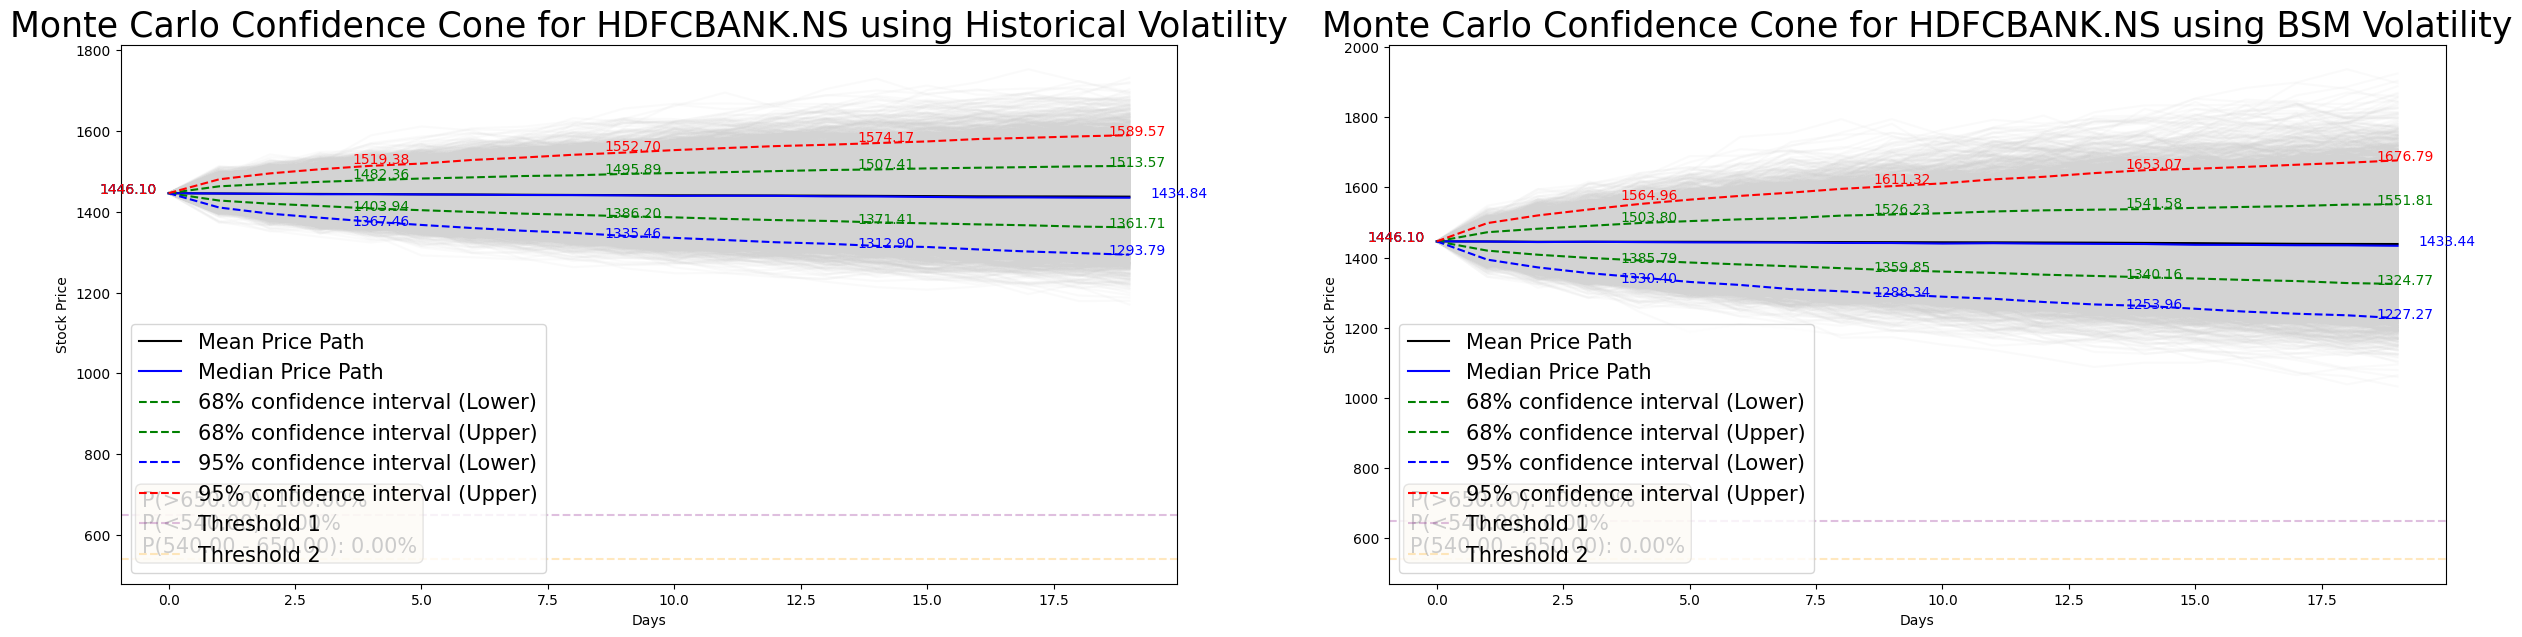

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm

# Download historical data for ASML.AS
symbol = "HDFCBANK.NS"
start_date = "2023-01-01"
end_date = "2024-03-11"
df = yf.download(symbol, start=start_date, end=end_date)

# Calculate daily returns
log_returns = np.log(df['Close'] / df['Close'].shift(1))

# Monte Carlo simulation parameters
days_to_forecast = 20
num_simulations = 10000
dt = 1  # 1 trading day

# Define thresholds
threshold2 = 540 #144 #116
threshold1 = 650 #162 #128

# Volatility for BSM
volatility_bsm = 0.29 # Assuming 29% annualized volatility

print("BMS Implied Volatility: ", volatility_bsm)

# Run Monte Carlo simulations
def run_simulation(volatility, dt, annualized=False):
    simulated_prices = np.zeros((days_to_forecast, num_simulations))
    simulated_prices[0] = df['Close'][-1]

    # Adjust volatility for annualized estimates
    if annualized:
        volatility = volatility / np.sqrt(252)

    for t in range(1, days_to_forecast):
        random_walk = np.random.normal(loc=log_returns.mean() * dt,
                                       scale=volatility * np.sqrt(dt),
                                       size=num_simulations)
        simulated_prices[t] = simulated_prices[t - 1] * np.exp(random_walk)
    return simulated_prices

simulated_prices_historical = run_simulation(log_returns.std(), dt)
simulated_prices_bsm = run_simulation(volatility_bsm, dt, annualized=True)

print("Historical Volatility: ", log_returns.std())

# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(30, 7))

for simulated_prices, ax, title in zip([simulated_prices_historical, simulated_prices_bsm], axs, ['Historical Volatility', 'BSM Volatility']):
    mean_price_path = np.mean(simulated_prices, axis=1)
    median_price_path = np.median(simulated_prices, axis=1)
    lower_bound_68 = np.percentile(simulated_prices, 16, axis=1)
    upper_bound_68 = np.percentile(simulated_prices, 84, axis=1)
    lower_bound_95 = np.percentile(simulated_prices, 2.5, axis=1)
    upper_bound_95 = np.percentile(simulated_prices, 97.5, axis=1)

    # Define thresholds
    threshold1 = threshold1
    threshold2 = threshold2

    ax.plot(simulated_prices, color='lightgray', alpha=0.1)
    ax.plot(mean_price_path, color='black', label='Mean Price Path')
    ax.plot(median_price_path, color='blue', label='Median Price Path')
    ax.plot(lower_bound_68, color='green', linestyle='--', label='68% confidence interval (Lower)')
    ax.plot(upper_bound_68, color='green', linestyle='--', label='68% confidence interval (Upper)')
    ax.plot(lower_bound_95, color='blue', linestyle='--', label='95% confidence interval (Lower)')
    ax.plot(upper_bound_95, color='red', linestyle='--', label='95% confidence interval (Upper)')

    ax.axhline(y=threshold1, color='purple', linestyle='--', alpha=0.25, label='Threshold 1')
    ax.axhline(y=threshold2, color='orange', linestyle='--', alpha=0.25, label='Threshold 2')

    # Plot settings
    ax.set_xlabel('Days')
    ax.set_ylabel('Stock Price')
    ax.set_title(f'Monte Carlo Confidence Cone for {symbol} using {title}', fontsize = 25)
    ax.legend(fontsize = 15)

    # Add price estimates every 5 days
    for day in range(0, days_to_forecast, 5):
        ax.annotate(f'{lower_bound_68[day]:.2f}', xy=(day, lower_bound_68[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='green')
        ax.annotate(f'{upper_bound_68[day]:.2f}', xy=(day, upper_bound_68[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='green')
        ax.annotate(f'{lower_bound_95[day]:.2f}', xy=(day, lower_bound_95[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='blue')
        ax.annotate(f'{upper_bound_95[day]:.2f}', xy=(day, upper_bound_95[day]), xycoords='data',
                    xytext=(-50, 0), textcoords='offset points', color='red')

    # Add probability annotations
    above_threshold1_prob = (simulated_prices[-1] > threshold1).sum() / num_simulations
    below_threshold2_prob = (simulated_prices[-1] < threshold2).sum() / num_simulations
    between_thresholds_prob = 1 - above_threshold1_prob - below_threshold2_prob

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.05, f'P(>{threshold1:.2f}): {above_threshold1_prob:.2%}\n'
                       f'P(<{threshold2:.2f}): {below_threshold2_prob:.2%}\n'
                       f'P({threshold2:.2f} - {threshold1:.2f}): {between_thresholds_prob:.2%}',
            transform=ax.transAxes, fontsize=15,
            verticalalignment='bottom', bbox=props)

    # Add mean price path labels
    #ax.annotate(f'{mean_price_path[-1]:.2f}', xy=(days_to_forecast - 1, mean_price_path[-1]), xycoords='data',
    #            xytext=(15, 0), textcoords='offset points', color='black')

    # Add median price path labels
    ax.annotate(f'{median_price_path[-1]:.2f}', xy=(days_to_forecast - 1, median_price_path[-1]), xycoords='data',
                xytext=(15, 0), textcoords='offset points', color='blue')

    # Add price labels
    ax.annotate(f'{lower_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_68[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='green')
    ax.annotate(f'{upper_bound_68[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_68[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='green')
    ax.annotate(f'{lower_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, lower_bound_95[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='blue')
    ax.annotate(f'{upper_bound_95[-1]:.2f}', xy=(days_to_forecast - 1, upper_bound_95[-1]), xycoords='data',
                xytext=(-15, 0), textcoords='offset points', color='red')

plt.show()